### Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

### **Data Preprocessing**

In [2]:
# Generate data paths with labels
# data_dir = '/Dataset brain'

data_dir = r'./Dataset brain/brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,./Dataset brain/brain_tumor_dataset\no\1 no.jpeg,no
1,./Dataset brain/brain_tumor_dataset\no\10 no.jpg,no
2,./Dataset brain/brain_tumor_dataset\no\11 no.jpg,no
3,./Dataset brain/brain_tumor_dataset\no\12 no.jpg,no
4,./Dataset brain/brain_tumor_dataset\no\13 no.jpg,no
...,...,...
248,./Dataset brain/brain_tumor_dataset\yes\Y95.jpg,yes
249,./Dataset brain/brain_tumor_dataset\yes\Y96.jpg,yes
250,./Dataset brain/brain_tumor_dataset\yes\Y97.JPG,yes
251,./Dataset brain/brain_tumor_dataset\yes\Y98.JPG,yes


### **Split data into train, valid, and test**

In [5]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

### **Create image data generator**

In [6]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


### **Show sample from train data**

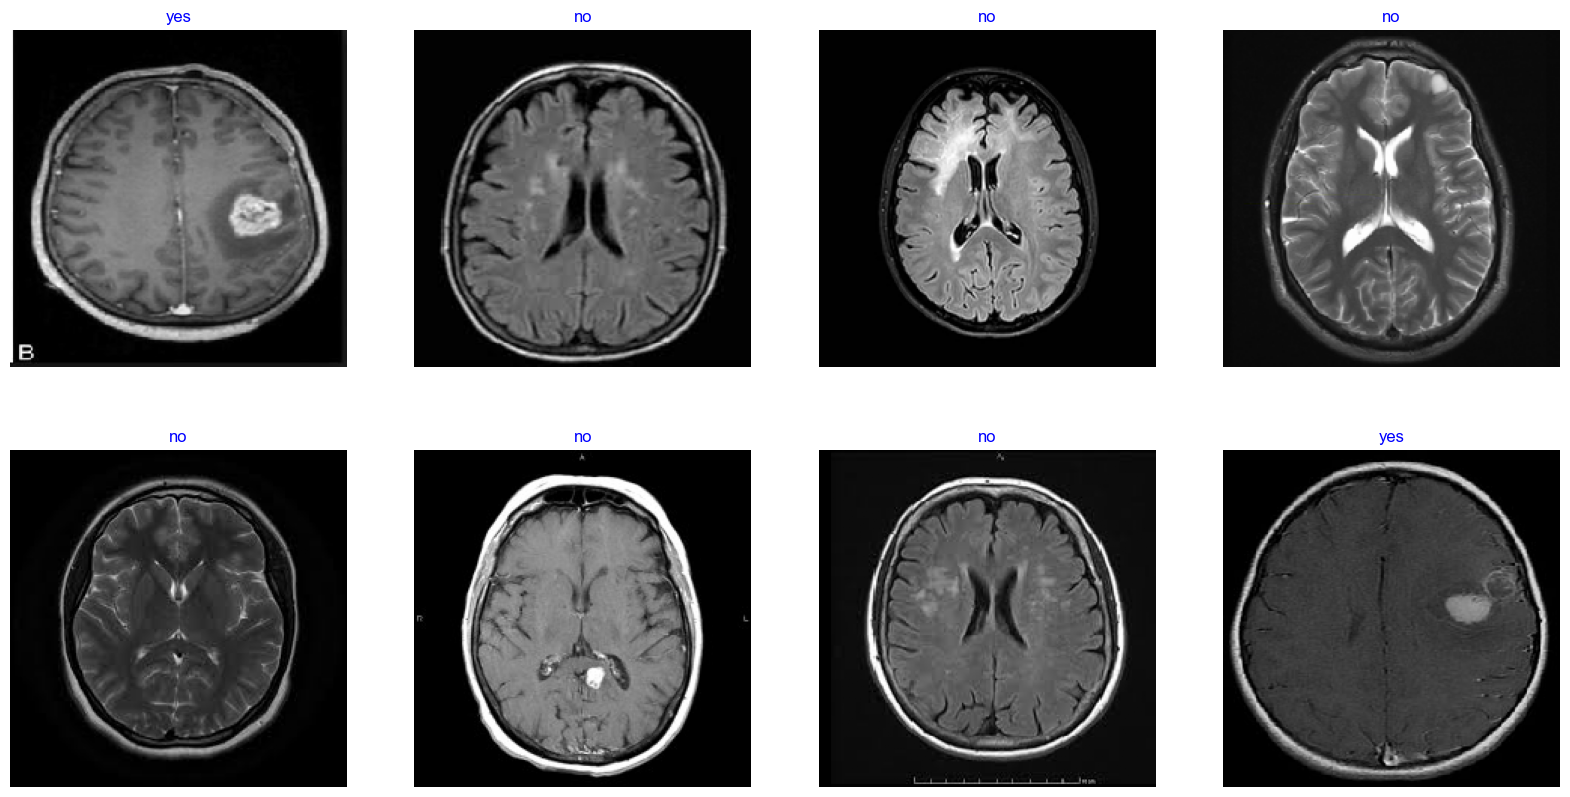

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # Assuming you have a 'train_gen' generator

# Create pre-trained model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

#### **Train model**

In [9]:
epochs = 30   # number of epochs and batch size is 26

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,validation_steps= None, shuffle= False)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.6555 - loss: 14.0192 - val_accuracy: 0.6078 - val_loss: 18.7667
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7883 - loss: 11.7232 - val_accuracy: 0.5490 - val_loss: 16.1672
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8467 - loss: 9.1103 - val_accuracy: 0.7451 - val_loss: 12.5117
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8217 - loss: 8.0905 - val_accuracy: 0.8235 - val_loss: 9.0580
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8037 - loss: 6.8833 - val_accuracy: 0.8431 - val_loss: 7.5164
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7272 - loss: 6.5920 - val_accuracy: 0.8431 - val_loss: 7.0766
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7798 - loss: 6.2304 - val_accuracy: 0.8235 - val_loss: 6.5433
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9015 - loss: 6.0703 - val_accuracy: 0.8431 - val

# **Evaluate model**

In [10]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - accuracy: 0.9568 - loss: 3.0961
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.8966 - loss: 3.1509
Train Loss:  3.083240032196045
Train Accuracy:  0.9504950642585754
--------------------
Test Loss:  3.1332764625549316
Test Accuracy:  0.9019607901573181


# **Get Predictions**

In [12]:
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing
import numpy as np

def predict_tumor(image_path, model):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read the image. Please check the file path or file format.")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize the image to match the input shape of the model (224x224)
    resized_image = cv2.resize(image, (224, 224))

    # Preprocess the resized image (apply any necessary normalization or other preprocessing steps)

    # Make prediction on the preprocessed image
    prediction = model.predict(np.expand_dims(resized_image, axis=0))
    predicted_class = np.argmax(prediction)

    # Plot the image
    plt.figure(figsize=(3, 2))
    plt.imshow(image)
    plt.title('Image with Tumor' if predicted_class == 1 else 'Image without Tumor')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


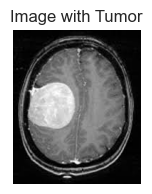

In [13]:
# Example usage
image_path = "./Y1.jpg"  # Replace with the path to your image
predict_tumor(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


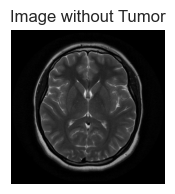

In [14]:
# Example usage
image_path = "./1no.jpeg"  # Replace with the path to your image
predict_tumor(image_path, model)